# Inference with Mask2Former

[Mask2Former](https://huggingface.co/docs/transformers/main/en/model_doc/mask2former) is a very nice new model from Meta AI, capable of solving any type of image segmentation (whether it's instance, semantic or panoptic segmentation) using the same architecture. The model improves upon [DETR](https://huggingface.co/docs/transformers/model_doc/detr) and [MaskFormer](https://huggingface.co/docs/transformers/model_doc/maskformer) by incorporating masked attention in its Transformer decoder.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/mask2former_architecture.jpg" alt="drawing" width="500"/>

In this notebook, we'll illustrate inference with this model (i.e. making predictions on a new image) for panoptic, semantic and instance segmentation.

## Set-up environment

First, we install 🤗 Transformers. We install from Github here since the Mask2Former model is brand new at the time of writing.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [36]:
import json
f = open('sidewalk-semantic/id2label.json') 
   
id2label = json.load(f)
id2label = {int(k):v for k,v in id2label.items()}
print(id2label)

{0: 'unlabeled', 1: 'flat-road', 2: 'flat-sidewalk', 3: 'flat-crosswalk', 4: 'flat-cyclinglane', 5: 'flat-parkingdriveway', 6: 'flat-railtrack', 7: 'flat-curb', 8: 'human-person', 9: 'human-rider', 10: 'vehicle-car', 11: 'vehicle-truck', 12: 'vehicle-bus', 13: 'vehicle-tramtrain', 14: 'vehicle-motorcycle', 15: 'vehicle-bicycle', 16: 'vehicle-caravan', 17: 'vehicle-cartrailer', 18: 'construction-building', 19: 'construction-door', 20: 'construction-wall', 21: 'construction-fenceguardrail', 22: 'construction-bridge', 23: 'construction-tunnel', 24: 'construction-stairs', 25: 'object-pole', 26: 'object-trafficsign', 27: 'object-trafficlight', 28: 'nature-vegetation', 29: 'nature-terrain', 30: 'sky', 31: 'void-ground', 32: 'void-dynamic', 33: 'void-static', 34: 'void-unclear'}


In [37]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-small-ade-semantic",                                                
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-small-ade-semantic",
                                                          id2label=id2label,
                                                          ignore_mismatched_sizes=True)

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-small-ade-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([151]) in the checkpoint and torch.Size([36]) in the model instantiated
- class_predictor.weight: found shape torch.Size([151, 256]) in the checkpoint and torch.Size([36, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([151]) in the checkpoint and torch.Size([36]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Let's load an image from the CityScapes dataset.

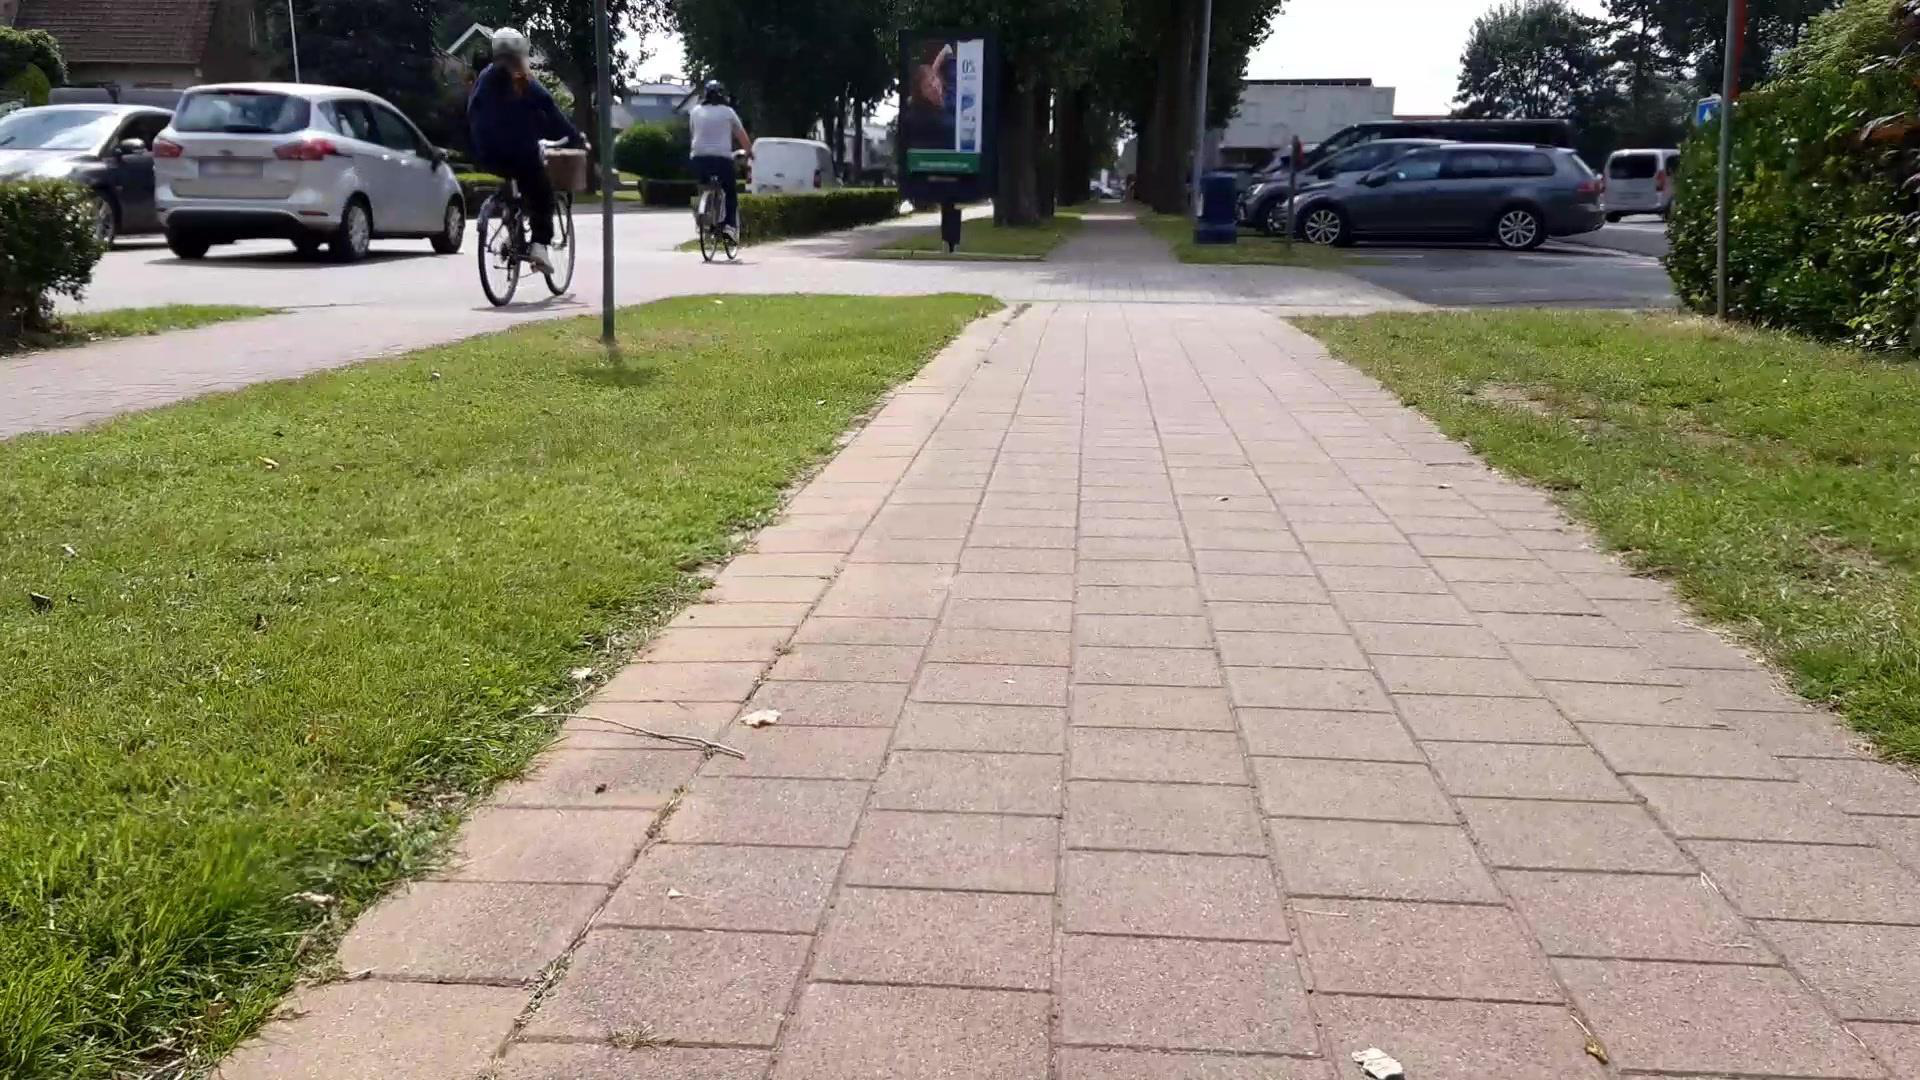

In [41]:
from PIL import Image
import requests

# url = 'https://cdn-media.huggingface.co/Inference-API/Sample-results-on-the-Cityscapes-dataset-The-above-images-show-how-our-method-can-handle.png'
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open('geeks.jpg')
image

In [42]:
inputs = processor(images=image, return_tensors="pt")
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 384, 384])
pixel_mask torch.Size([1, 384, 384])


In [43]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**inputs)

In [44]:
# you can pass them to processor for postprocessing
predicted_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(predicted_map.shape)

torch.Size([1080, 1920])


We can draw the semantic segmentation map (with one label per pixel) over the image:

In [45]:
import numpy as np
# generate random color palette, which maps each class to a RGB value
color_palette = [list(np.random.choice(range(256), size=3)) for _ in range(len(model.config.id2label))]
print(color_palette)

[[212, 64, 249], [11, 78, 145], [2, 233, 157], [136, 134, 94], [38, 210, 68], [130, 157, 106], [165, 154, 246], [133, 171, 48], [45, 187, 53], [254, 228, 190], [19, 68, 162], [10, 101, 117], [71, 138, 224], [8, 31, 136], [163, 13, 234], [58, 148, 12], [105, 6, 125], [90, 195, 204], [26, 155, 191], [134, 195, 177], [205, 0, 141], [199, 178, 57], [146, 180, 68], [158, 140, 116], [113, 208, 165], [66, 0, 237], [170, 114, 188], [154, 31, 152], [80, 232, 85], [94, 181, 192], [96, 176, 43], [209, 135, 184], [240, 142, 252], [191, 228, 102], [200, 251, 61]]


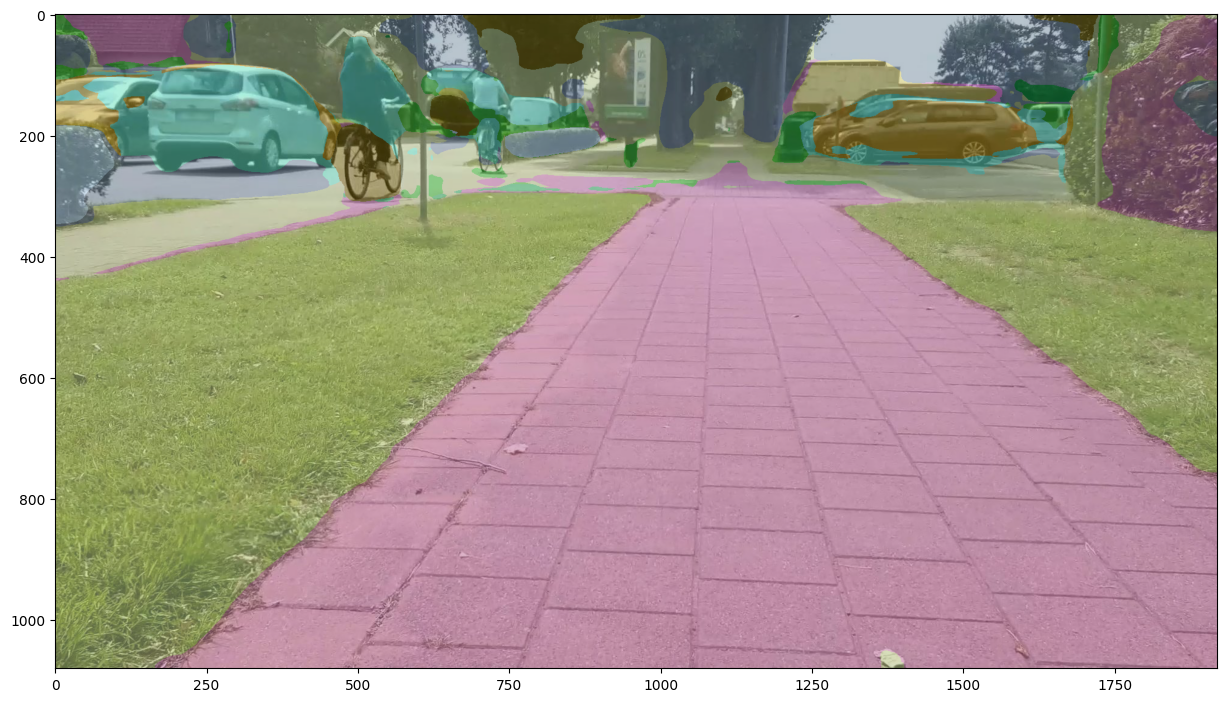

In [46]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

seg = predicted_map
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(color_palette)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()